In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

from dataloader import *
from utils import *
from models.CNN import CNNForecaster

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


(7096, 4, 10) (7096, 4, 1) (1774, 4, 10) (1774, 4, 1)


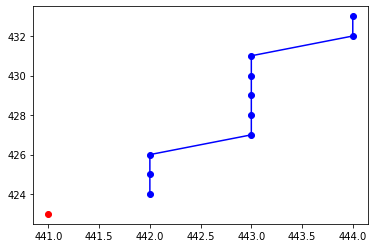

In [2]:
# Load the data
path = 'data/box_training_data/'
x_train = np.load(path + 'x_train.npy').astype(np.float32)
y_train = np.load(path + 'y_train.npy').astype(np.float32)
x_test = np.load(path + 'x_test.npy').astype(np.float32)
y_test = np.load(path + 'y_test.npy').astype(np.float32)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_sample, y_sample = x_train[0], y_train[0]
plt.plot(x_sample[0], x_sample[1], 'bo-')
plt.plot(y_sample[0], y_sample[1], 'ro-')
plt.show()

In [3]:
"""
Create dataloaders for training and testing with batch size 32
"""

class ForecastDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
def create_dataloader(features, labels, batch_size=1):
    train_ds = ForecastDataset(features, labels)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    return train_dl

train_dataloader = create_dataloader(x_train, y_train, batch_size=32)
test_dataloader = create_dataloader(x_test, y_test, batch_size=32)

In [4]:
def train(model, train_dataloader, test_dataloader, epochs, optimizer, criterion):
    """
    Train the model for the given number of epochs
    """
    # Keep track of training and validation loss
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(epochs)):
        # Training
        avg_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            # Forward pass
            y_pred = model(x)
            # Compute loss
            loss = criterion(y_pred.view(y_pred.size(0), 4), y.view(y.size(0), 4))
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
                    
        avg_loss = avg_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs} | Loss: {avg_loss:.4f}')
        
        # Validation
        avg_loss = 0
        for i, (x, y) in enumerate(test_dataloader):
            x = x.to(device)
            y = y.to(device)
            # Forward pass
            y_pred = model(x)
            # Compute loss
            loss = criterion(y_pred.view(y_pred.size(0), 4), y.view(y.size(0), 4))
            avg_loss += loss.item()
            
        avg_loss = avg_loss / len(test_dataloader)
        test_losses.append(loss.item())
        print(f'Epoch {epoch + 1}/{epochs} | Validation Loss: {avg_loss:.4f}')
    
    return train_losses, test_losses

def average_displacement_loss(y_pred, y):
    """
    Compute the average displacement loss from two tensors
    """
    return torch.mean(torch.norm(y_pred - y, 2, dim=1))

    def euclidean_distance(x, y):
        return torch.sqrt(torch.sum((x - y)**2))

    losses = []
    for batch in range(y_pred.shape[0]):
        distance_sum = 0
        for i in range(y_pred.shape[1]):
            distance_sum += euclidean_distance(y_pred[batch, i], y[batch, i])
        distance_sum = distance_sum / y_pred.shape[1]
        losses += [distance_sum]
    
    return torch.mean(torch.Tensor(losses))
    
def final_displacement_loss(y_pred, y):
    """
    Compute the final displacement loss from two tensors
    """
    def euclidean_distance(x, y):
        return torch.sqrt(torch.sum((x - y)**2))

    losses = []
    for batch in range(y_pred.shape[0]):
        distance = euclidean_distance(y_pred[batch, -1], y[batch, -1])
        losses += [distance]
    
    return torch.mean(torch.Tensor(losses))


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500 | Loss: 125012.7619
Epoch 1/500 | Validation Loss: 93839.5869
Epoch 2/500 | Loss: 67846.4749
Epoch 2/500 | Validation Loss: 42824.0768
Epoch 3/500 | Loss: 26831.7199
Epoch 3/500 | Validation Loss: 15361.5945
Epoch 4/500 | Loss: 11232.0269
Epoch 4/500 | Validation Loss: 8500.2181
Epoch 5/500 | Loss: 7098.3267
Epoch 5/500 | Validation Loss: 5885.9944
Epoch 6/500 | Loss: 4980.3374
Epoch 6/500 | Validation Loss: 4251.0049
Epoch 7/500 | Loss: 3670.6386
Epoch 7/500 | Validation Loss: 3264.9546
Epoch 8/500 | Loss: 2845.4090
Epoch 8/500 | Validation Loss: 2600.9851
Epoch 9/500 | Loss: 2225.4173
Epoch 9/500 | Validation Loss: 1999.9731
Epoch 10/500 | Loss: 1709.7424
Epoch 10/500 | Validation Loss: 1522.4455
Epoch 11/500 | Loss: 1272.9537
Epoch 11/500 | Validation Loss: 1111.0225
Epoch 12/500 | Loss: 897.0665
Epoch 12/500 | Validation Loss: 757.3587
Epoch 13/500 | Loss: 613.4959
Epoch 13/500 | Validation Loss: 531.8170
Epoch 14/500 | Loss: 440.8451
Epoch 14/500 | Validation Loss: 399

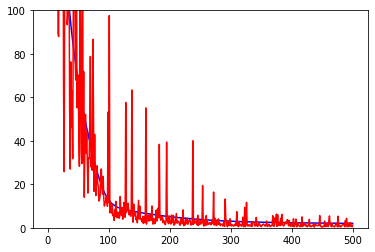

In [12]:
EPOCHS = 500

model = CNNForecaster((4, 10), (4, 1), 2, 0.0, 32)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()
# criterion = average_displacement_loss

# for i in tqdm(range(1, 15)):
#     model = CNNForecaster((4, 20), (4, 20), i, 0.2, 32)
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.MSELoss()
train_loss, test_loss = train(model, train_dataloader, test_dataloader, epochs=EPOCHS, optimizer=optimizer, criterion=criterion)
# print(f'{i} CNN LAYERS:', min(test_loss))

plt.plot(range(1, EPOCHS+1), train_loss, 'b-', label='Training Loss')
plt.plot(range(1, EPOCHS+1), test_loss, 'r-', label='Validation Loss')
plt.ylim(0, 100)
plt.show()

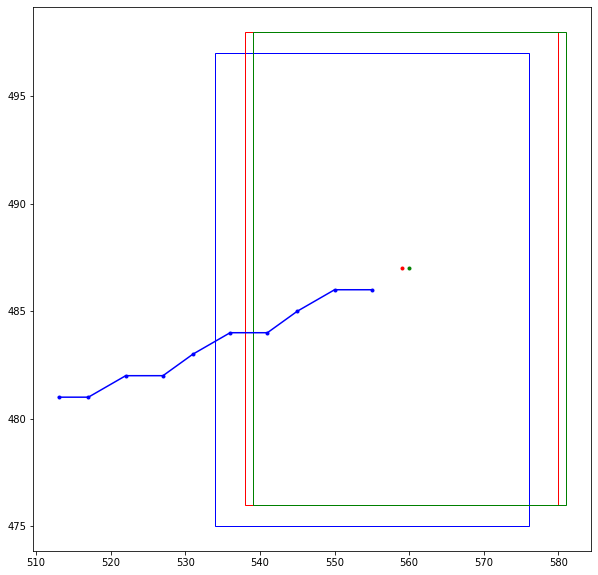

(tensor(0.2500), tensor(1.), tensor(0.))


In [29]:
from matplotlib.patches import Rectangle

def evaluate(model, x_test, y_test):
    """
    Evaluate the model on the test set
    """
    y_pred = model(x_test.to(device))
    y_pred = y_pred.detach().cpu()
    y_pred = torch.round(y_pred)
    y_pred, y_test = y_pred.view(y_pred.size(0), 4), y_test.view(y_test.size(0), 4)
    mse = criterion(y_pred, y_test)
    l1 = average_displacement_loss(y_pred, y_test)
    l2 = final_displacement_loss(y_pred, y_test)
    

    def midpoint(arr):
        arr = arr[0]
        x = arr[0] + .5 * arr[2]
        y = arr[1] + .5 * arr[3]
        return np.array([x.numpy(), y.numpy()])
    
    x_mid = midpoint(x_test)
    y_test_mid = midpoint(y_test)
    y_pred_mid = midpoint(y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_mid[0], x_mid[1], 'b.-')
    ax.plot(y_test_mid[0], y_test_mid[1], 'r.-')
    ax.plot(y_pred_mid[0], y_pred_mid[1], 'g.-')
    ax.add_patch(Rectangle((x_test[0, 0, -1], x_test[0, 1, -1]), x_test[0, 2, -1], x_test[0, 3, -1], fill=False, edgecolor='blue'))
    ax.add_patch(Rectangle((y_test[0, 0], y_test[0, 1]), y_test[0, 2], y_test[0, 3], fill=False, edgecolor='red'))
    ax.add_patch(Rectangle((y_pred[0, 0], y_pred[0, 1]), y_pred[0, 2], y_pred[0, 3], fill=False, edgecolor='green'))

    plt.show()
    
    return mse, l1, l2

model.eval()
x_batch, y_batch = next(iter(test_dataloader))
x_sample, y_sample = x_batch[0].view(1, 4, 10), y_batch[0].view(1, 4, 1)
print(evaluate(model, x_sample, y_sample))

In [30]:
from datetime import datetime as dt

hist = torch.randn((1, 4, 10)).to(device)

start = dt.now()

for i in range(240):
    pred = torch.round(model(hist[:, :, -10:]))
    hist = torch.cat((hist, pred.unsqueeze(-1)), dim=-1)

end = dt.now()

print("Time Taken:", end - start)


AttributeError: ignored

In [ ]:
torch.save(model.state_dict(), 'saved_models/model.pt')